loss at step  10 :  18.6702
loss at step  20 :  9.07031
loss at step  30 :  5.8296
loss at step  40 :  4.96202
loss at step  50 :  3.49207
loss at step  60 :  2.55358
loss at step  70 :  5.34405
loss at step  80 :  3.15899
loss at step  90 :  2.69325
loss at step  100 :  2.92424
loss at step  110 :  3.39295
loss at step  120 :  3.21451
loss at step  130 :  3.76525
loss at step  140 :  2.8134
loss at step  150 :  3.12577
loss at step  160 :  3.33273
loss at step  170 :  3.62227
loss at step  180 :  3.94758
loss at step  190 :  2.63063
loss at step  200 :  3.75386
loss at step  210 :  2.7674
loss at step  220 :  2.67275
loss at step  230 :  2.56296
loss at step  240 :  2.97678
loss at step  250 :  3.35773
loss at step  260 :  2.61502
loss at step  270 :  2.84059
loss at step  280 :  2.29108
loss at step  290 :  3.0157
loss at step  300 :  2.57483


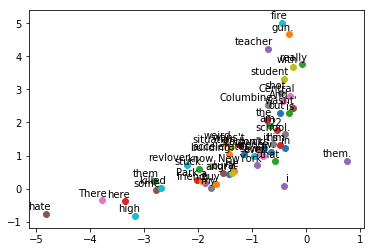

In [27]:
# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


model_path = "C:/Users/Jangwon/Documents/Tensorflow/modeltest.ckpt"


# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["i hate him",
             "There is a fire at the starbucks building. ",
             "I am a teacher at Columbine high school.",
             "There is a student here with a gun.",
             "He shot out a window.",
             "some guy killed my friend.",
             "I saw that situation I am in NewYork Central Park.",
             "And our accelerator is stuck.",
             "I shot them with a 22 revlover. ",
             "I don't know, I wans't it's weird I wasnt' even really angry with them. "]

# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dict = {w: i for i, w in enumerate(word_list)}
#print(word_dict)
# 윈도우 사이즈를 1 로 하는 skip-gram 모델을 만듭니다.
# 예) 나 게임 만화 애니 좋다
#   -> ([나, 만화], 게임), ([게임, 애니], 만화), ([만화, 좋다], 애니)
#   -> (게임, 나), (게임, 만화), (만화, 게임), (만화, 애니), (애니, 만화), (애니, 좋다)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    # 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장합니다
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])


# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels


#########
# 옵션 설정
######
# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 이 예제에서는 x, y 그래프로 표현하기 쉽게 2 개의 값만 출력하도록 합니다.
embedding_size = 2
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)


#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))

# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)
# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))


# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

#########
# 신경망 모델 학습
######
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(2, training_epoch + 2):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)

            
            
    # Save model weights to disk
    #save_path = saver.save(sess, model_path)
    #print("Model saved in file: %s" % save_path)

    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장합니다.
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()
    
#########
# 임베딩된 Word2Vec 결과 확인
# 결과는 해당 단어들이 얼마나 다른 단어와 인접해 있는지를 보여줍니다.
######
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

In [4]:
'''
Save and Restore a model using TensorFlow.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import tensorflow as tf

# Parameters
learning_rate = 0.001
batch_size = 100
display_step = 1
model_path = "C:/Users/Jangwon/Documents/Tensorflow/model.ckpt"

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()



# Running first session
print("Starting 1st session...")
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training cycle
    for epoch in range(3):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("First Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)



# Running a new session
print("Starting 2nd session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Restore model weights from previously saved model
    saver.restore(sess, model_path)
    print("Model restored from file: %s" % save_path)

    # Resume training
    for epoch in range(10):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Second Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval(
        {x: mnist.test.images, y: mnist.test.labels}))





Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Starting 1st session...
Epoch: 0001 cost= 166.645385465
Epoch: 0002 cost= 40.238892890
Epoch: 0003 cost= 25.174754185
First Optimization Finished!
Accuracy: 0.91
Model saved in file: C:/Users/Jangwon/Documents/Tensorflow/model.ckpt
Starting 2nd session...
INFO:tensorflow:Restoring parameters from C:/Users/Jangwon/Documents/Tensorflow/model.ckpt
Model restored from file: C:/Users/Jangwon/Documents/Tensorflow/model.ckpt
Epoch: 0001 cost= 17.438398295
Epoch: 0002 cost= 12.728967921
Epoch: 0003 cost= 9.322904876
Epoch: 0004 cost= 7.081686193
Epoch: 0005 cost= 5.218760884
Epoch: 0006 cost= 3.909250549
Epoch: 0007 cost= 2.883625172
Epoch: 0008 cost= 2.204796480
Epoch: 0009 cost= 1.617871439
Epoch: 0010 cost= 1.241216391
Second Optimization Finished!
Accuracy: 0.944
